# Example of Uplift Modeling

In [1]:
import copy

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
from pycalf.uplift import UpliftModel
from pycalf.visualize import plot_auuc

In [3]:
csv_file = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
df = pd.read_csv(csv_file)

In [4]:
print(df.shape)
df.head()

(64000, 12)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [5]:
def one_hot_encode(data: pd.DataFrame, column: str):
    ohe = pd.get_dummies(data[column]).add_prefix(f'{column}_')
    data = data.drop(column, axis=1)
    data = data.join(ohe)
    return data

# Use only user data send E-Mail.
df = df.loc[df["segment"] != "No E-Mail"].reset_index(drop=True)

for col in ['zip_code', 'channel']:
    df = one_hot_encode(df, col)

features = df.columns.difference(["segment","visit","conversion","spend","history_segment"])

scaler = preprocessing.MinMaxScaler()
df[features] = scaler.fit_transform(df[features].to_numpy())

X = df[features]
treatment = df['segment'].map({"Mens E-Mail": 1, "Womens E-Mail": 0}).astype(bool)
y = df['visit'].astype(bool)

"""クラスの外でデータを作る"""
X_train, X_test, z_train, z_test, y_train, y_test = train_test_split(X, treatment, y, test_size=0.5, random_state=42)

In [6]:
print(X.shape)
display(X.head())

print(treatment.shape)
display(treatment.head())

print(y.shape)
display(y.head())

(42694, 11)


,channel_Multichannel,channel_Phone,channel_Web,history,mens,newbie,recency,womens,zip_code_Rural,zip_code_Surburban,zip_code_Urban
0,0.0,1.0,0.0,0.035295,1.0,0.0,0.818182,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.047288,0.0,1.0,0.545455,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.202713,1.0,1.0,0.727273,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.004818,1.0,0.0,0.090909,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.032907,0.0,0.0,0.454545,1.0,0.0,1.0,0.0


(42694,)


0    False
1    False
2     True
3    False
4    False
Name: segment, dtype: bool

(42694,)


0    False
1    False
2    False
3    False
4     True
Name: visit, dtype: bool

In [7]:
X_treat, y_treat = X_train[z_train == 1], y_train[z_train == 1]
X_control, y_control = X_train[z_train == 0], y_train[z_train == 0]


learner = LogisticRegression(solver='lbfgs', C=0.1, max_iter=100, random_state=42)
learner_treat = copy.deepcopy(learner)
learner_control = copy.deepcopy(learner)
model = UpliftModel(learner_treat, learner_control)
model.fit(X_treat, y_treat, X_control, y_control)

uplift_score, lift = model.predict(X_test, z_test.to_numpy(), y_test.to_numpy())

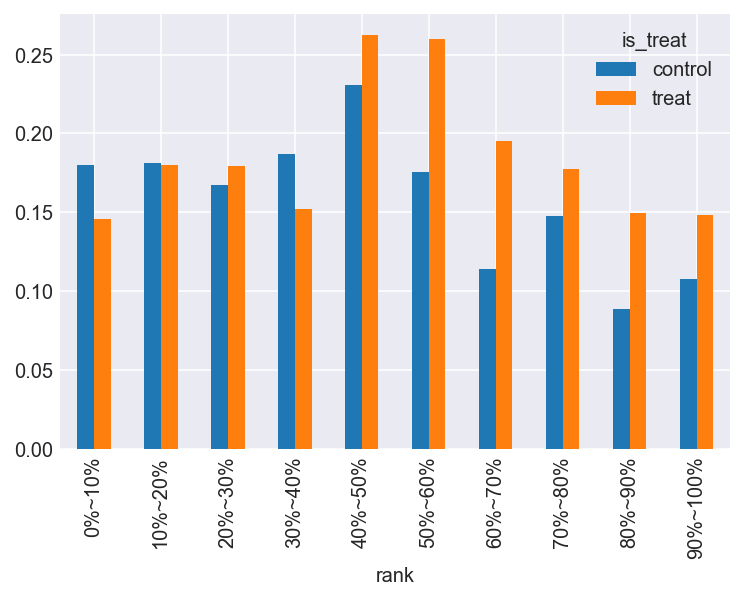

In [8]:
uplift_score = model.estimate_uplift_score(X_test)
result = list(zip(y_test, z_test, uplift_score))
result.sort(key=lambda x: x[2], reverse=True)

qdf = pd.DataFrame(result, columns=('cv', 'is_treat', 'uplift_sore'))
qdf['rank'] = pd.qcut(qdf['uplift_sore'], 10, labels=["{}%~{}%".format(n*10, (n+1)*10) for n in range(10)])
qdf['is_treat'] = qdf['is_treat'].map({False: 'control', True: 'treat'})

pivot_qdf = qdf.pivot_table(index='rank', columns='is_treat', values='cv', aggfunc=np.mean)
pivot_qdf.plot(kind='bar')

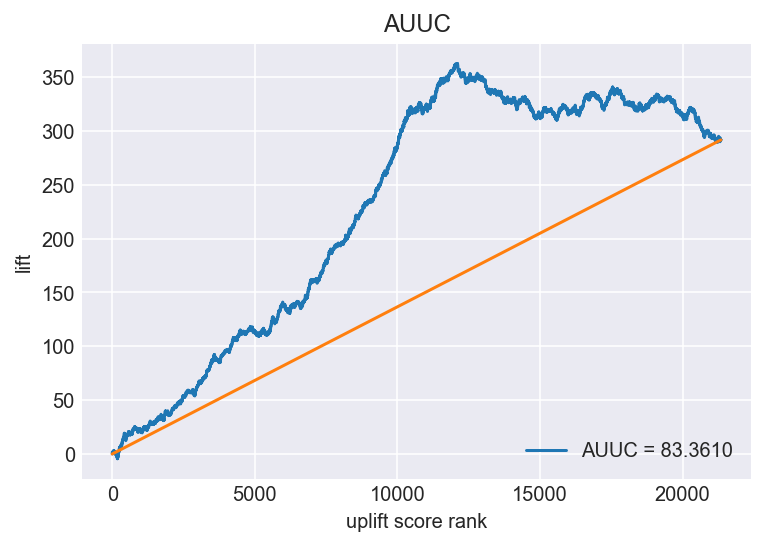

In [9]:
auuc_score = model.get_auuc(lift)
base_line = model.get_baseline(lift)
plot_auuc(uplift_score, lift, base_line, auuc_score)

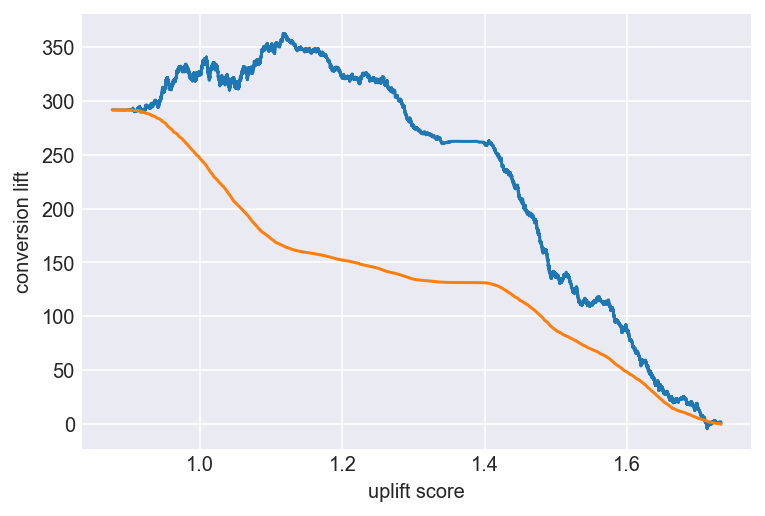

In [10]:
uplift_score, lift = model.predict(X_test, z_test.to_numpy(), y_test.to_numpy())
base_line = model.get_baseline(lift)

plt.plot(uplift_score, lift)
plt.plot(uplift_score, base_line)
plt.xlabel("uplift score")
plt.ylabel("conversion lift")
plt.show()